In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.special import ndtri  # norm inv
from scipy.stats import t        # t student

# tk libs
from lib.objs.tkpaths import Site
#from lib.statistical import ksdensity_CDF, ksdensity_ICDF, copulafit, copularnd


# --------------------------------------
# def statistical functions
def ksdensity_CDF(x):
    '''
    Kernel smoothing function estimate.
    Returns cumulative probability function at x.
    '''

    # fit a univariate KDE
    kde = sm.nonparametric.KDEUnivariate(x)
    kde.fit()

    # interpolate KDE CDF at x position (kde.support = x) 
    fint = interp1d(kde.support, kde.cdf)

    # plot CDF
    plotit = True
    if plotit:
        plt.plot(kde.support, kde.cdf,'k', label='')
        plt.plot(x, fint(x),'.r', label='fit points')
        plt.title('ksdensity CDF')
        plt.xlabel('x')
        plt.ylabel('CDF')
        plt.legend()
        plt.show()

    return fint(x)

def ksdensity_ICDF(x, p):
    '''
    Returns Inverse Kernel smoothing function at p points
    '''

    # fit a univariate KDE
    kde = sm.nonparametric.KDEUnivariate(x)
    kde.fit()

    # interpolate KDE CDF to get support values 
    fint = interp1d(kde.cdf, kde.support)

    # ensure p inside kde.cdf
    p[p<np.min(kde.cdf)] = kde.cdf[0]
    p[p>np.max(kde.cdf)] = kde.cdf[-1]

    plotit = True
    if plotit:
        plt.plot(kde.cdf, kde.support, 'k', label='')
        plt.plot(p, fint(p), '.r', label='sim points')
        plt.title('ksdensity CDF')
        plt.xlabel('CDF')
        plt.ylabel('x')
        plt.legend()
        plt.show()

    return fint(p)

def copulafit(u, family='gaussian'):
    '''
    Fit copula to data.
    Returns correlation matrix and degrees of freedom for t student
    '''

    rhohat = None  # correlation matrix
    nuhat = None  # degrees of freedom (for t student) 

    if family=='gaussian':
        inv_n = ndtri(u)
        rhohat = np.corrcoef(inv_n.T)

    elif family=='t':
        raise ValueError("Not implemented")

        # TODO: no encaja con los datos. no funciona 
        x = np.linspace(np.min(u), np.max(u),100)
        inv_t = np.ndarray((len(x), u.shape[1]))

        for j in range(u.shape[1]):
            param = t.fit(u[:,j])
            t_pdf = t.pdf(x,loc=param[0],scale=param[1],df=param[2])
            inv_t[:,j] = t_pdf

        # TODO CORRELACION? NUHAT?
        rhohat = np.corrcoef(inv_n.T)
        nuhat = None

    else:
        raise ValueError("Wrong family parameter. Use 'gaussian' or 't'")

    return rhohat, nuhat

def copularnd(family, rhohat, n):
    '''
    Random vectors from a copula
    '''

    if family=='gaussian':
        mn = np.zeros(rhohat.shape[0])
        np_rmn = np.random.multivariate_normal(mn, rhohat, n)
        u = norm.cdf(np_rmn)

    elif family=='t':
        # TODO
        raise ValueError("Not implemented")

    else:
        raise ValueError("Wrong family parameter. Use 'gaussian' or 't'")

    return u


In [3]:
# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

# input files
p_sst_KMA = site.pc.site.SST.kma

# parameters
num_clusters = int(site.params.SST_AWT.num_clusters)


i 0 --- kma_num 0 --- PC1



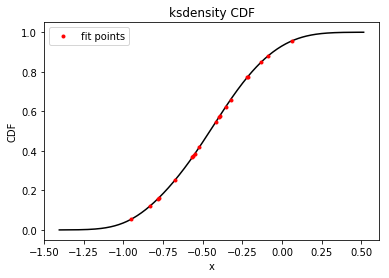

i 0 --- kma_num 0 --- PC2



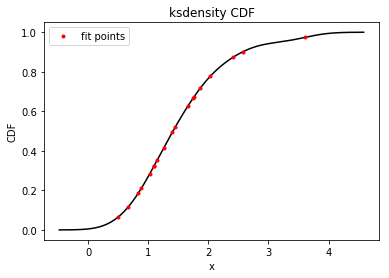

i 0 --- kma_num 0 --- PC3



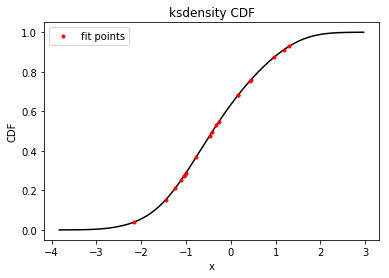

i 0 --- kma_num 0 --- PC1_rnd



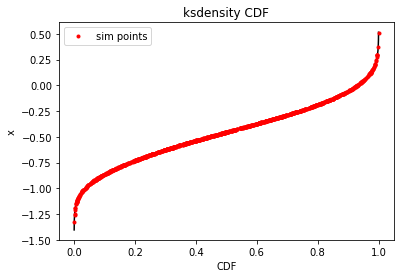

i 0 --- kma_num 0 --- PC2_rnd



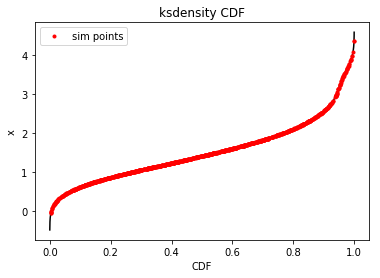

i 0 --- kma_num 0 --- PC3_rnd



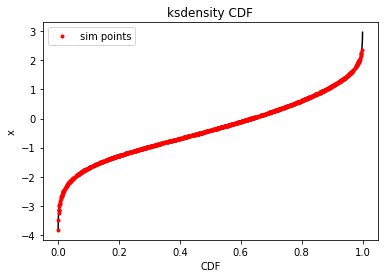





i 1 --- kma_num 5 --- PC1



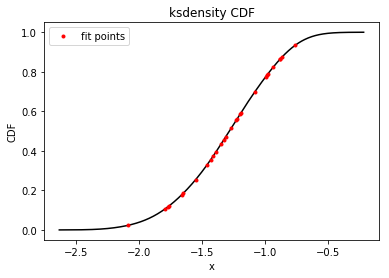

i 1 --- kma_num 5 --- PC2



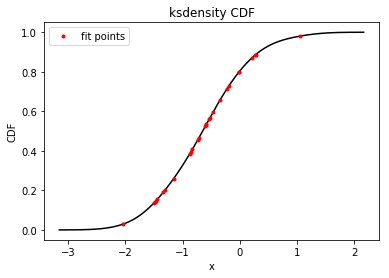

i 1 --- kma_num 5 --- PC3



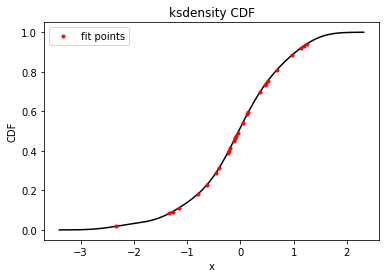

i 1 --- kma_num 5 --- PC1_rnd



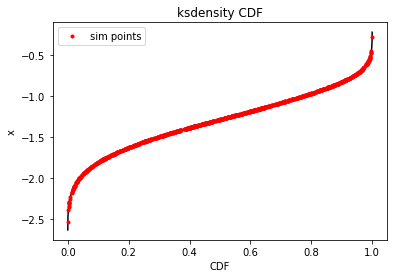

i 1 --- kma_num 5 --- PC2_rnd



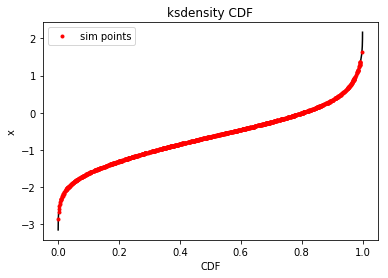

i 1 --- kma_num 5 --- PC3_rnd



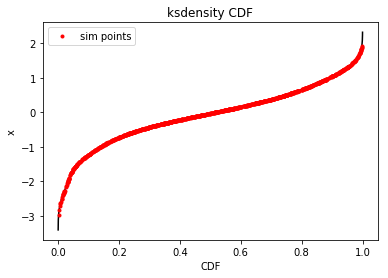





i 2 --- kma_num 3 --- PC1



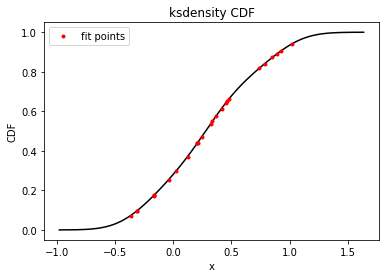

i 2 --- kma_num 3 --- PC2



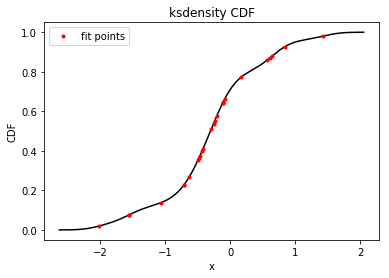

i 2 --- kma_num 3 --- PC3



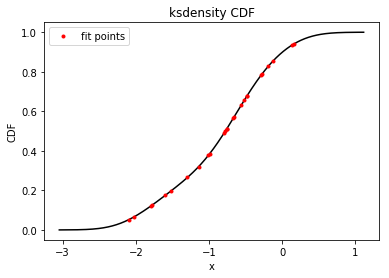

i 2 --- kma_num 3 --- PC1_rnd



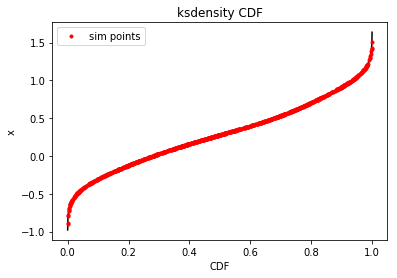

i 2 --- kma_num 3 --- PC2_rnd



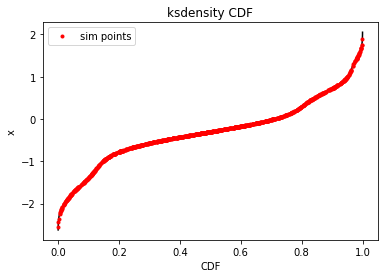

i 2 --- kma_num 3 --- PC3_rnd



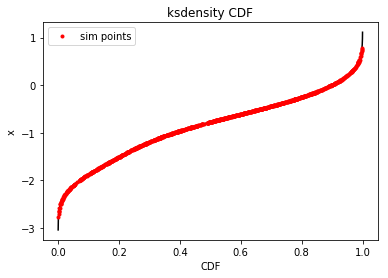





i 3 --- kma_num 2 --- PC1



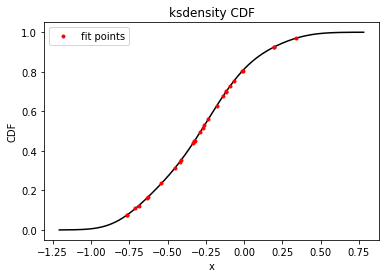

i 3 --- kma_num 2 --- PC2



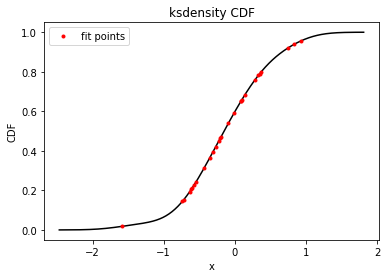

i 3 --- kma_num 2 --- PC3



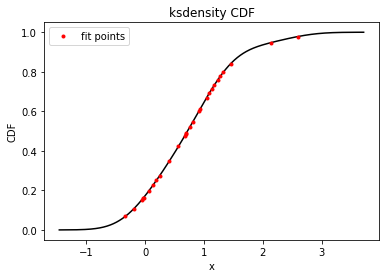

i 3 --- kma_num 2 --- PC1_rnd



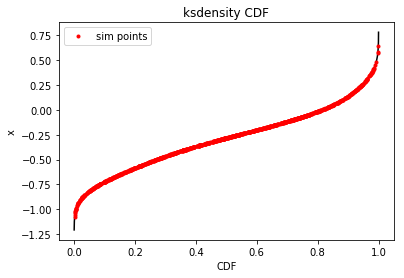

i 3 --- kma_num 2 --- PC2_rnd



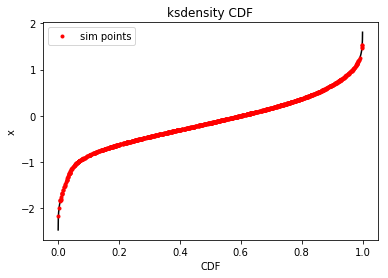

i 3 --- kma_num 2 --- PC3_rnd



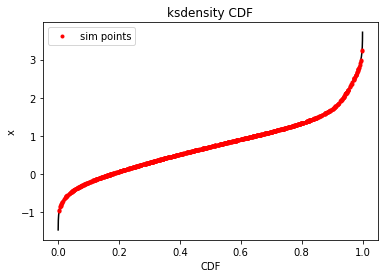





i 4 --- kma_num 1 --- PC1



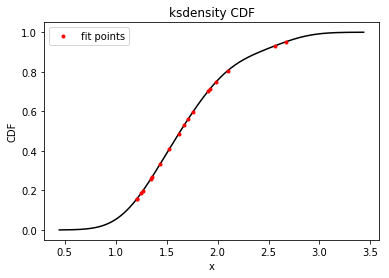

i 4 --- kma_num 1 --- PC2



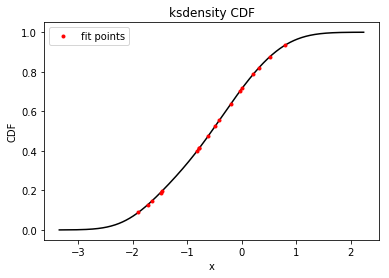

i 4 --- kma_num 1 --- PC3



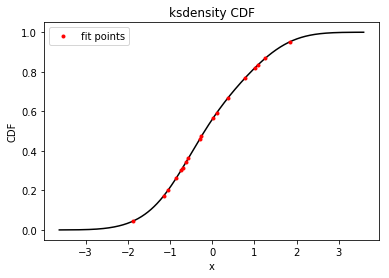

i 4 --- kma_num 1 --- PC1_rnd



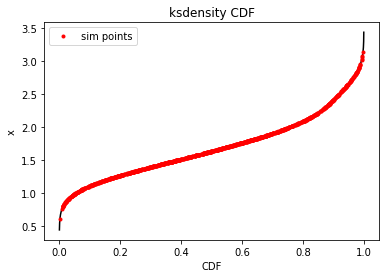

i 4 --- kma_num 1 --- PC2_rnd



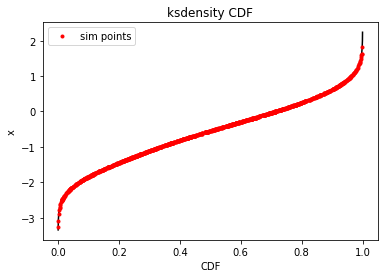

i 4 --- kma_num 1 --- PC3_rnd



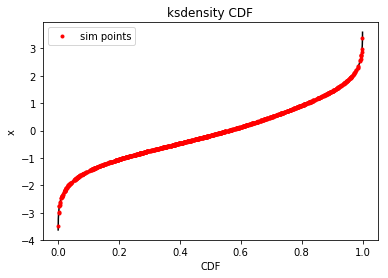





i 5 --- kma_num 4 --- PC1



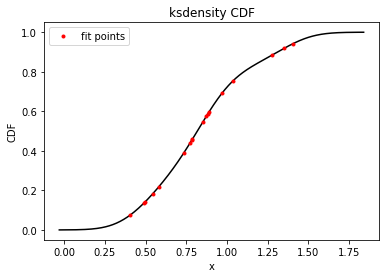

i 5 --- kma_num 4 --- PC2



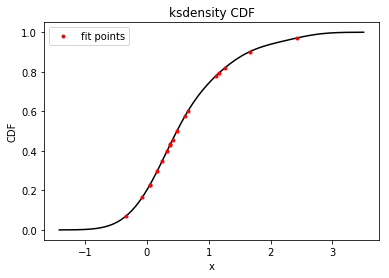

i 5 --- kma_num 4 --- PC3



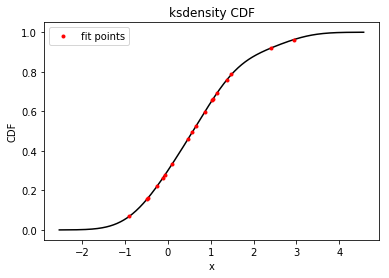

i 5 --- kma_num 4 --- PC1_rnd



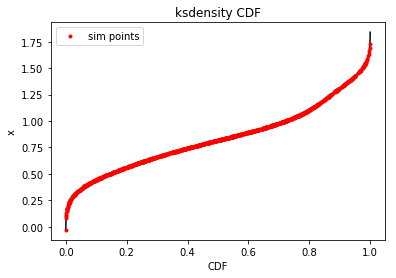

i 5 --- kma_num 4 --- PC2_rnd



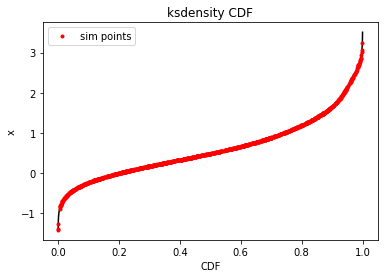

i 5 --- kma_num 4 --- PC3_rnd



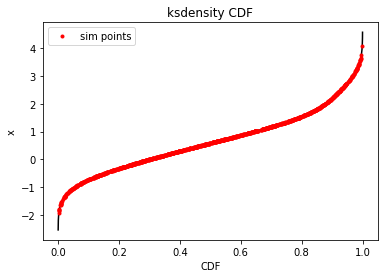

In [4]:
# --------------------------------------
# TODO: CALCULATE PC_SIM 1,2,3

# Load data
xds_AWT = xr.open_dataset(p_sst_KMA)

# bmus and order
kma_order = xds_AWT.order.values
kma_labels = xds_AWT.bmus.values

# first 3 PCs
PCs = xds_AWT.PCs.values
variance = xds_AWT.variance.values
PC1 = np.divide(PCs[:,0], np.sqrt(variance[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(variance[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(variance[2]))

# for each WT: generate copulas and simulate data 
for i in range(num_clusters):

    # getting copula number from plotting order
    num = kma_order[i]
    
    # find all the best match units equal
    ind = np.where(kma_labels == num)[:]
    
    # transfom data using kernel estimator
    print('i {0} --- kma_num {1} --- PC1\n'.format(i,num))
    cdf_PC1 = ksdensity_CDF(PC1[ind])
    print('i {0} --- kma_num {1} --- PC2\n'.format(i,num))
    cdf_PC2 = ksdensity_CDF(PC2[ind])
    print('i {0} --- kma_num {1} --- PC3\n'.format(i,num))
    cdf_PC3 = ksdensity_CDF(PC3[ind])
    U = np.column_stack((cdf_PC1.T, cdf_PC2.T, cdf_PC3.T))

    # fit PCs CDFs to a gaussian copula 
    rhohat, _ = copulafit(U, 'gaussian')

    # simulate data to fill probabilistic space
    U_sim = copularnd('gaussian', rhohat, 1000)
    print('i {0} --- kma_num {1} --- PC1_rnd\n'.format(i,num))
    PC1_rnd = ksdensity_ICDF(PC1[ind], U_sim[:,0])
    print('i {0} --- kma_num {1} --- PC2_rnd\n'.format(i,num))
    PC2_rnd = ksdensity_ICDF(PC2[ind], U_sim[:,1])
    print('i {0} --- kma_num {1} --- PC3_rnd\n'.format(i,num))
    PC3_rnd = ksdensity_ICDF(PC3[ind], U_sim[:,2])
    print('\n\n\n')

